In [52]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import datetime
import numpy as np
import pandas as pd
import rioxarray as rxr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import polars as pl #libs for faster data processing


from dateutil import tz
import geopandas as gpd

from pyproj import CRS


import sklearn.metrics as metrics
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression


os.chdir('/Users/gaurav/UAH/temperature_modelling/')

#Custom modules
import lib.satellite as sat
import lib.dataprocess as dp 
from lib import helper
from lib import modeller as mod
from lib import crowqdc as cqc


#For the issue with .loc[]
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'crowqdc' from 'lib' (unknown location)

### Step 1 : Clean Data 

Run     : python lib/cleaner.py Madison 2021 <br>
Output  : New clean data saved in /Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/clean_Madison_pws_.csv

In [3]:
#updating necessary columns from satellite
necessary_col_sat = ['station', 'beg_time', 'latitude', 'longitude', 
                # 'humidityAvg',
                  'temperature',
               # 'windspeed', 'dewpt', 'heatindex', 'precipRate',
               'day_of_year',
               'hour', 'adjusted_lst', 'valueImperviousfraction', 'valueTreefraction',
               'valueBuildingheight', 'valueNearestDistWater', 'valueWaterfraction',
               # 'valueLandcover', 
               'valueBuildingfraction']

#updating temporal columns
spatial_columns = [ 'station', 'beg_time', 'latitude','longitude',
                     'temperature', 
                     'closest_station_1_temp','closest_station_2_temp','closest_station_3_temp',
                     'closest_1_distance','closest_2_distance','closest_3_distance',
                     ]

##### Note : 
# 1. valueLandcover is not included as it is categorical
default_location = 'Madison'
default_year = 2021


In [5]:
#Readin PWS Data
### Step 1 : Clean Data 
#Run     : python lib/cleaner.py Madison 2021 <br>
#Output  : New clean data saved in /Users/gaurav/UAH/temperature_modelling/data/processed_data/Madison_2021/clean_Madison_pws_.csv

clean_data = pd.read_csv('data/processed_data/Madison_2021/clean_Madison_pws_.csv')
# clean_data = pd.read_csv('data/processed_data/Madison_2022/clean_Madison_pws_.csv')
clean_data['beg_time'] = pd.to_datetime(clean_data['beg_time'])
clean_data['hour'] = clean_data['beg_time'].dt.hour

clean_data = clean_data.query("day_of_year >= 30 & day_of_year <= 210")
clean_data.station = clean_data.station.str.upper()

# dp.plot_(clean_data,'day_of_year',200)


### Step 2: Generate Ecostress and Urban Satellite Data

In [544]:
sat.create_station_file('Madison',2021,urban_data=False)
# sat.create_station_file('Madison',2021,urban_data=True)

/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/interpolated_temperature_01.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_16.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_02.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_14.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/temperature_00.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory/interpolated_temperature_17.tif
/Users/gaurav/UAH/temperature_modelling/../ECOSTRESS_and_urban_surface_dataset/Madison/ECOSTRESS/adjusted_output_directory

### Step 4 : Calculate Adjsuted LST


#### Note : 
By now I have access to : <br>
- One **clean_data** dataframe that records hourly temperature for each station for 1 year.
-  **result_df** dataframe that has adjusted LST temperature (i.e. LST-mean(LST)).
- **urban_data** dataframe that has urban surface properties.
    - The **valueLandcover** column is categorical

In [6]:
# This data consists of stations, lat, long, time, temp adjusted lst and all surface values
#The process raster data function is used to download the satellite data and process it

eco_data = mod.process_raster_data(clean_data,create=False,year=default_year,location=default_location)
eco_data = eco_data[necessary_col_sat]

### Step 5 : EDA of urban surface properties 

### Step 6 : Modelling Data

In [7]:
#This data combines stations with closest stations
temperature_data = helper.find_closest_temperatures(eco_data)


#### Step 6.1 : Strategy for Null Values

1. Filling null closest temperature vallues with interpolation
2. In the future, it can be replaced with second closest or average

#### Step 6.2 : Splitting into sequences


**Model 1 : Linear Regression**

In [8]:
from sklearn.preprocessing import StandardScaler

window_size = 5
#Its here because I don't want to pass final_df everytime
def get_partitions(final_df,col_list,selection_hour,scaler=False):
    ''' Get final split of data based on hour selected
        selection_hour = [1] or None
    '''
    final_df_x = final_df.query(f'hour == {list([selection_hour or list(np.arange(0,24,1))][0])}')
    X_train, X_test, y_train, y_test = mod.get_train_test_data(final_df_x,window_size)
    hour_status = final_df_x.hour.unique()

    d_train, d_test = X_train[col_list], X_test[col_list]

    #if there is no hour column, then its set to none, such that the plotter function behaves accordingly
    # hour_status = True if 'hour' in d_train.columns else False

    if scaler:
        scaler = StandardScaler()

        d_train =  scaler.fit_transform(d_train)
        d_train = pd.DataFrame(d_train,columns=col_list)
        d_test = scaler.transform(d_test)
        d_test = pd.DataFrame(d_test,columns=col_list)

    return [d_train, d_test, y_train, y_test], hour_status


def bulk_model_runner(model,grouped_data,col_list,delete=True,bulk_mode=True,fit = True):
    ''' This function runs the model for all hours and saves the predictions and error
        grouped_data = data grouped by station
        col_list = columns to be used for modelling
        delete = True if you want to delete the contents of directory
        bulk_mode = True if you want to train one model for each hour
        fit = True if you want to fit the model, False if you want to load the model
    '''

    #random run to clean directory
    # if delete:
    #     hour = 21
    #     data,hour_status = get_partitions(grouped_data,col_list,[hour])  #or None
    #     predictions,error = mod.train_save(model, data, hour_status,clean_directory=True)

    #cleaning the directory first
    model_name = model.__class__.__name__
    model_path = os.path.join(mod.MODEL_PATH,model_name)
    helper.clean_directory(model_path)

    model_dict = {}
    if bulk_mode:
        for hour_ in range(24):
            data,hour_status = get_partitions(grouped_data,col_list,[hour_])  #or None
            predictions,error = mod.train_save(model, data, hour_status,clean_directory=False)
            try:
                feature_importances = model.feature_importances_
            except:
                feature_importances = None
            model_dict[hour_] = [predictions,error,feature_importances]
    
    if not bulk_mode:
        data,hour_status = get_partitions(grouped_data,col_list,None)
        predictions,error = mod.train_save(model, data, hour_status,clean_directory=False)
        try:
            feature_importances = model.feature_importances_
        except:
            feature_importances = None
        model_dict[25] = [predictions,error,feature_importances]

    return model_dict

In [51]:
temperature_data_segment = temperature_data.query("beg_time >= '2021-06-01' & beg_time < '2021-07-01'")
final_df = mod.get_final_df(temperature_data_segment,eco_data,spatial_columns)
grouped_data = final_df.groupby(['station','hour']).mean().reset_index()

def level_1_plot(grouped_data):
    ''' This function plots the temperature pattern for all stations for June 2021
        Used to show initial pattern before cleaning
    '''
    grouped_datax = grouped_data.copy()
    grouped_datax['std_dev'] = grouped_datax.groupby('hour')['temperature'].transform('std')
    plt.figure(figsize=(12,8))
    plt.errorbar(grouped_datax.hour, grouped_datax.temperature, yerr=grouped_datax.std_dev, fmt='o', ecolor='orange', capthick=2)

    plt.xlabel('Hour')
    plt.title('Temperature Pattern for all station for June 2021')

    return plt


def cleaning_outliers(grouped_data,variation=20):
    ''' This function cleans the outliers from the data
        variation = 20 means that if the temperature is more than 20% of the average of closest stations, then its an outlier
    '''
    gd = grouped_data[['station', 'hour','latitude','longitude','temperature','closest_station_1_temp','closest_station_2_temp','closest_station_3_temp']]
    gd.loc[:,'average_temp'] = gd[['closest_station_1_temp','closest_station_2_temp','closest_station_3_temp']].mean(axis=1)

    gd['variation_closest'] = 100*abs(gd['temperature']-gd['average_temp'])/gd['average_temp']
    flags = gd[gd.variation_closest>20].groupby('station').count().index.values

    return flags

flags = cleaning_outliers(grouped_data)

# level_1_plot(grouped_data)
# level_1_plot(grouped_data[~grouped_data.station.isin(flags)])

def clean_missing_data(final_df):
    ''' Removing those stations which have a lot of missing data for weeks, months
    '''
    missing_stations = []
    for station_id in final_df.station.unique():
        data_segment = final_df[final_df.station==station_id]
        obs = data_segment.resample('D',on='beg_time').mean().reset_index().count()['temperature']
        if obs < 20:
            missing_stations.append(station_id)
            print(f'{station_id} has {obs} observations in June 2021')

    return missing_stations

missing_sts = clean_missing_data(final_df)



# ##New code to remove anomalies : Dec 17
# missing_stations = ['KWIFITCH35','KWIMADIS162','KWIMADIS353','KWIMADIS65','KWIMONON7','KWIWAUNA18']


KWIFITCH38 has 12 observations in June 2021
KWIMADIS162 has 18 observations in June 2021
KWIMADIS353 has 7 observations in June 2021
KWIMADIS65 has 15 observations in June 2021
KWIMIDDL19 has 19 observations in June 2021
KWIMONON7 has 10 observations in June 2021
KWIWAUNA18 has 19 observations in June 2021


In [48]:
missing_sts

['KWIFITCH38',
 'KWIMADIS162',
 'KWIMADIS353',
 'KWIMADIS65',
 'KWIMIDDL19',
 'KWIMONON7',
 'KWIWAUNA18']

In [49]:
flags

array(['KWIFITCH38', 'KWIMADIS298', 'KWIMADIS308', 'KWIMADIS50',
       'KWIMIDDL19', 'KWIMIDDL23', 'KWIMIDDL39'], dtype=object)

In [31]:
gd = final_df[['station', 'hour','latitude','longitude','temperature','closest_station_1_temp','closest_station_2_temp','closest_station_3_temp']]
gd.loc[:,'average_temp'] = gd[['closest_station_1_temp','closest_station_2_temp','closest_station_3_temp']].mean(axis=1)

gd['variation_closest'] = 100*abs(gd['temperature']-gd['average_temp'])/gd['average_temp']
flags = gd[gd.variation_closest>20].groupby('station').count().index.values

final_df_anomalous = final_df[final_df.station.isin(flags)]
final_df_normal = final_df[~final_df.station.isin(flags)]

final_df = final_df.query("station not in @flags")
# final_df = final_df.query("station not in @missing_stations")

grouped_data = final_df.groupby(['station','hour']).mean().reset_index()
# grouped_data['beg_time'] = final_df['beg_time'][0]



Text(0.5, 1.0, 'Temperature Pattern for all station for June 2021')

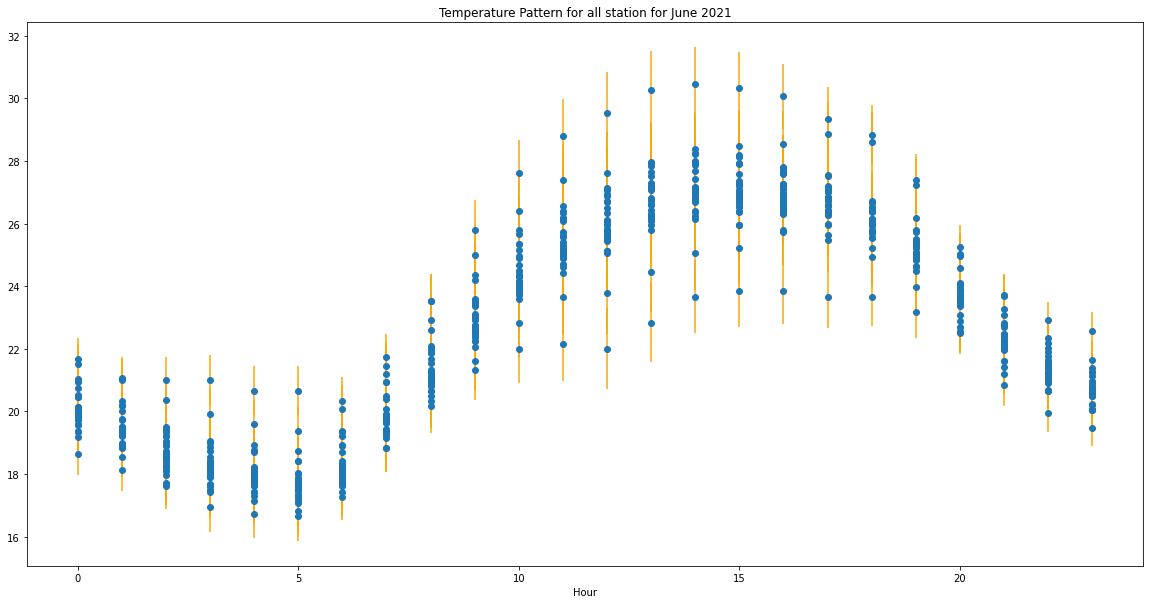

In [32]:
grouped_data['std_dev'] = grouped_data.groupby('hour')['temperature'].transform('std')
plt.figure(figsize=(20,10))
# plt.errorbar(grouped_data.hour, grouped_data.temperature, yerr=grouped_data.temperature.std(), fmt='o', ecolor='orange', capthick=2)
plt.errorbar(grouped_data.hour, grouped_data.temperature, yerr=grouped_data.std_dev, fmt='o', ecolor='orange', capthick=2)

plt.xlabel('Hour')
plt.title('Temperature Pattern for all station for June 2021')


In [18]:

#removing anomalies from 2. Station Analysis
# final_df = final_df.query("station not in @flags")
# final_df = final_df.query("station not in @missing_stations")

grouped_data = final_df.groupby(['station','hour']).mean().reset_index()
grouped_data['beg_time'] = final_df['beg_time'][0]

#WIll be used for plotting scatter plots
helper.convert_to_gpd(grouped_data,'epsg:4326',convert_to='epsg:6879')[['hour','latitude','longitude','temperature']].to_csv('Analytics/temp_data/grouped_data.csv',index=False)


In [728]:
grouped_data.to_csv('Analytics/temp_data/grouped_data_untouched.csv',index=False)

In [729]:
#group the grouped data by hour to find hourly mean and subtract it from the temperature

grouped_data['delta_temp'] = grouped_data['temperature']-grouped_data.groupby('hour')['temperature'].transform('mean')
grouped_data['old_temperature'] = grouped_data['temperature']
grouped_data['temperature'] = grouped_data['delta_temp']

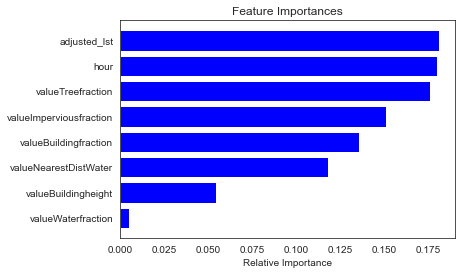

In [688]:
visualizer.plot_feature_importances(col_list,bulk_importances=model_dict[25][2])



In [775]:
hour_lookup['old_temperature'].to_dict()

{0: 20.143672209015637,
 1: 19.525026095945584,
 2: 18.797018789650203,
 3: 18.3068947584714,
 4: 18.001811683721083,
 5: 17.79328497059166,
 6: 18.361677483016177,
 7: 19.89781330819175,
 8: 21.554825965130917,
 9: 23.23730627824726,
 10: 24.744826259460673,
 11: 25.760448828608613,
 12: 26.456540185050216,
 13: 27.16935993614333,
 14: 27.611064706371053,
 15: 27.54699246797112,
 16: 27.395156518054712,
 17: 27.0651186796804,
 18: 26.41807033315961,
 19: 25.352711598122678,
 20: 23.766135521753704,
 21: 22.31646192390854,
 22: 21.409673774791617,
 23: 20.796427994720315}

In [734]:
hour_lookup = grouped_data.groupby('hour')['old_temperature'].mean().reset_index()
predictions = model_dict[25][0]

model_dict_updated = predictions.merge(hour_lookup,on='hour')
model_dict_updated['predicted_temperature'] = model_dict_updated['predicted_temperature']+model_dict_updated['old_temperature']
model_dict_updated['true_temperature'] = model_dict_updated['true_temperature']+model_dict_updated['old_temperature']

model_dict[25][0] = model_dict_updated



<AxesSubplot:>

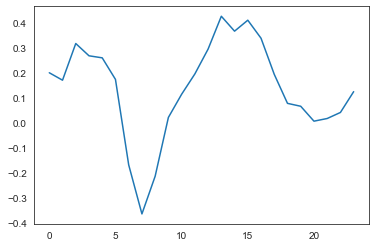

In [745]:
xf = model_dict[25][0].groupby('hour').mean()[['predicted_temperature','true_temperature']].reset_index()
xf['delta'] = xf.predicted_temperature - xf.true_temperature
xf.delta.plot()

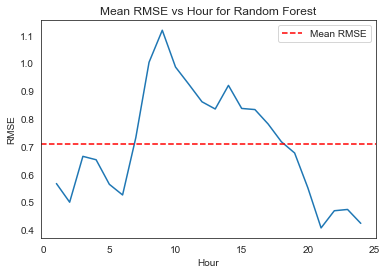

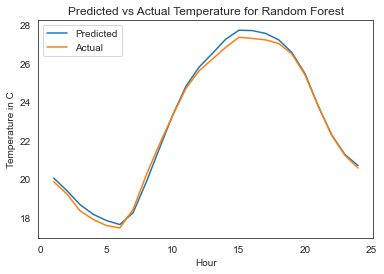

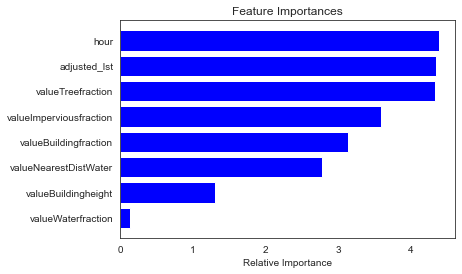

In [738]:
visualizer.plot_mean(model_dict,'Random Forest',col_list)

Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_0.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_1.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_2.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_3.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_4.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_5.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_6.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/LinearRegression/LinearRegression_7.sav
Model Saved : /Users/gaurav/UAH/temperature_mode

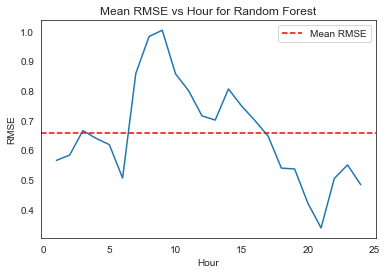

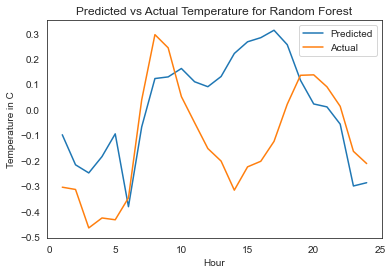

In [752]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']

# rrf = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=8,
#                             n_estimators=300)


# model_dict = bulk_model_runner(rrf,grouped_data,col_list,bulk_mode=False,delete=True)
# visualizer.plot_mean(model_dict,'Random Forest',col_list)


model = LinearRegression()
model_dict = bulk_model_runner(model,grouped_data,col_list,bulk_mode=True,delete=True)
visualizer.plot_mean(model_dict,'Random Forest',col_list)


In [768]:
for keys in model_dict.keys():
    model_dict[keys][0]['feature_importances'] = model_dict[keys][2]
    model_dict[keys][0]['hourly_rms'] = model_dict[keys][1]

hour0 = model_dict[0][0]

for keys in model_dict.keys():
    if keys != 0:
        hour0 = pd.concat([hour0,model_dict[keys][0]],axis=0)



In [771]:
hour0

,hour,adjusted_lst,valueImperviousfraction,valueTreefraction,valueBuildingheight,valueNearestDistWater,valueWaterfraction,valueBuildingfraction,predicted_temperature,true_temperature,feature_importances,hourly_rms
90,0,0.578309,35.166667,0.000000,0.0,0.001165,0.0,8.63611,-0.197330,-0.109189,None,0.565158
91,0,1.471642,52.333333,0.000000,0.0,0.000510,0.0,0.00000,0.107273,-0.350569,None,0.565158
92,0,1.238309,46.500000,10.250000,0.0,0.000650,0.0,12.44640,0.030868,1.166673,None,0.565158
93,0,0.804976,41.666667,0.000000,0.0,0.000496,0.0,0.00000,-0.126103,-0.660914,None,0.565158
94,0,0.364976,38.250000,0.000000,0.0,0.001674,0.0,0.00000,-0.256702,-0.557465,None,0.565158
...,...,...,...,...,...,...,...,...,...,...,...,...
95,23,0.413939,48.444444,12.222222,0.0,0.001767,0.0,14.12140,-0.199725,-0.382635,None,0.483025
96,23,1.100606,29.166667,12.333333,0.0,0.001259,0.0,9.66093,-0.191591,-0.210221,None,0.483025
97,23,0.747273,53.333333,7.000000,0.0,0.000555,0.0,12.49220,-0.078250,-0.313669,None,0.483025
98,23,-0.606061,54.000000,17.250000,0.0,0.000782,0.0,10.64280,-0.420637,-0.761945,None,0.483025


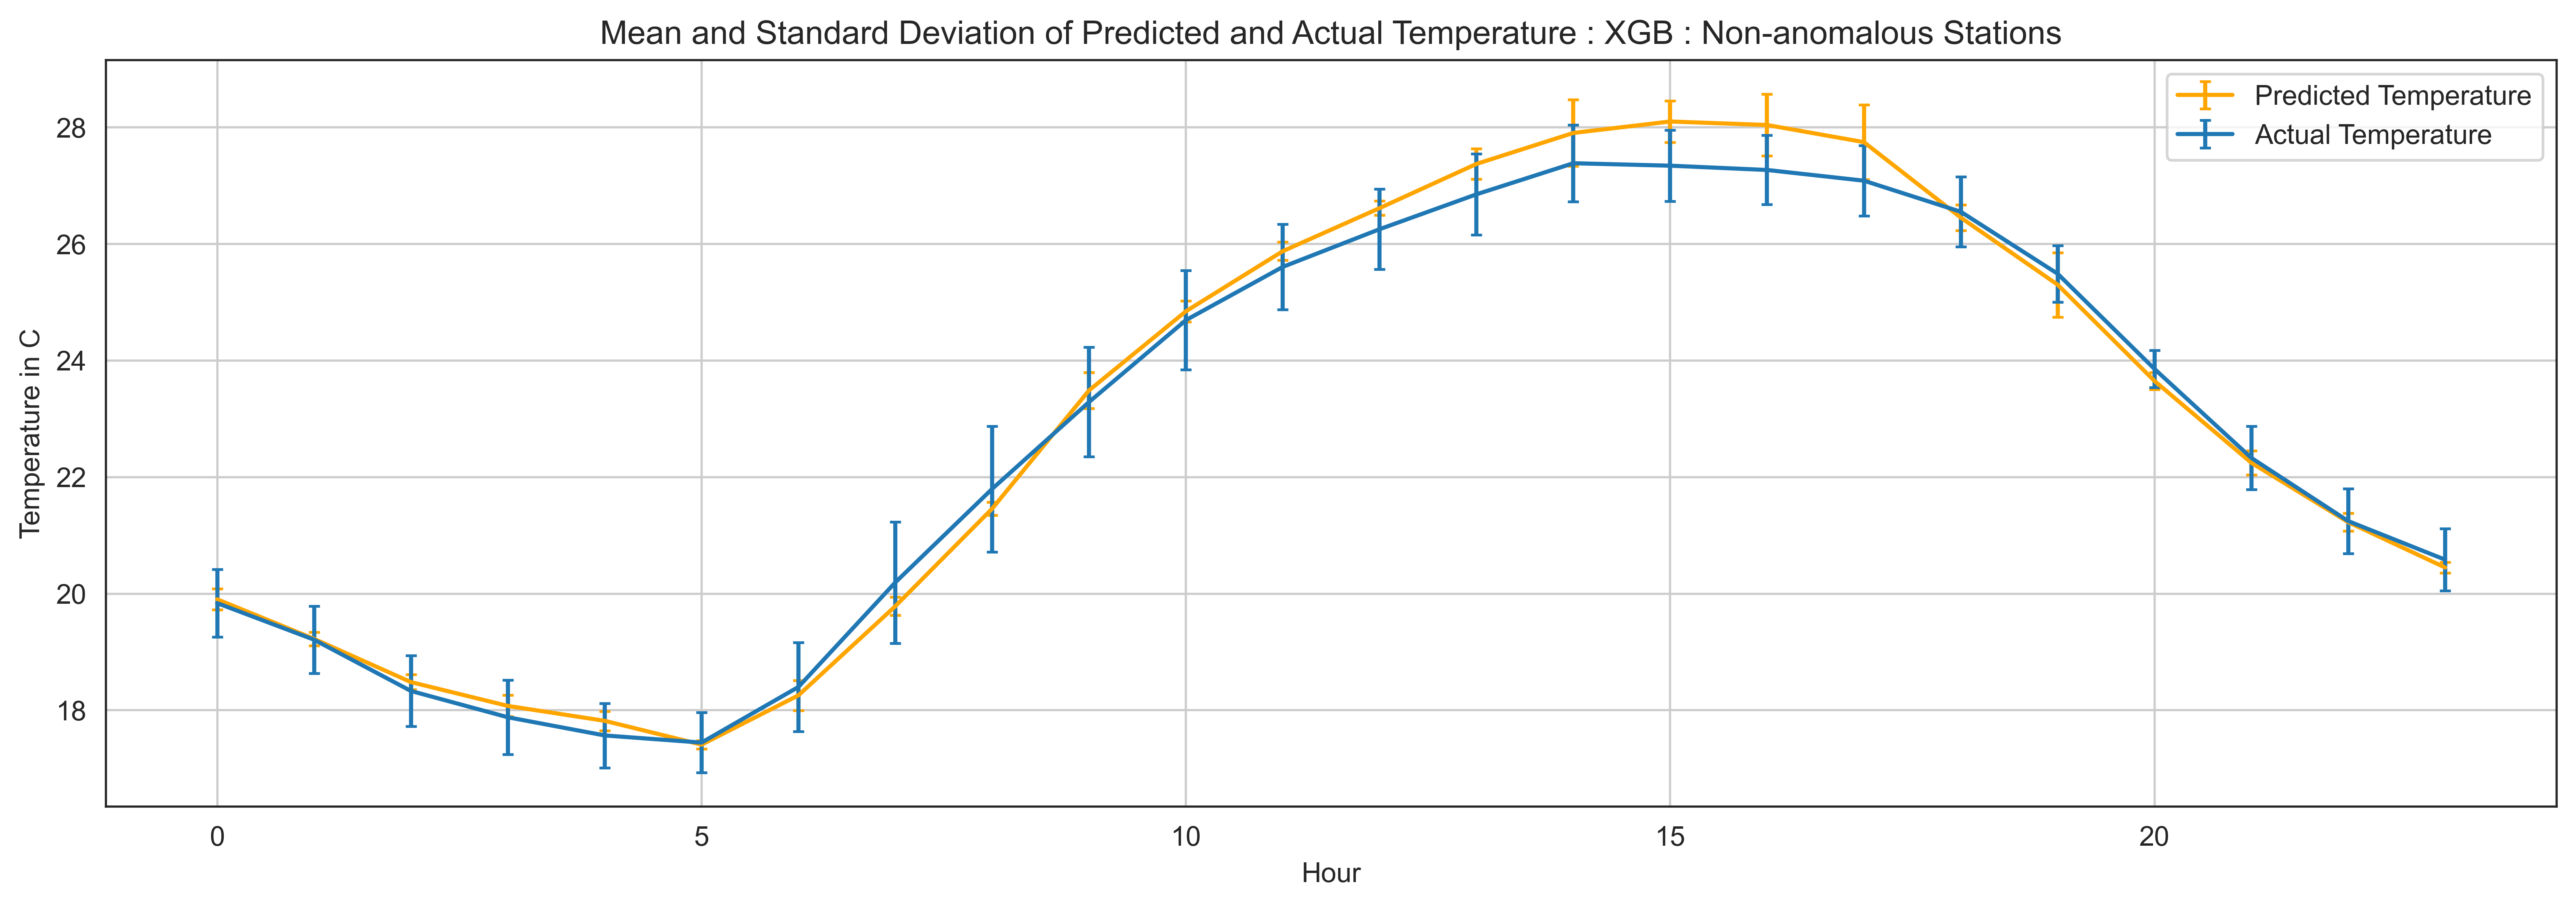

In [656]:
mean_predicted = []
std_predicted = []
mean_actual = []
std_actual = []
for hours in range(24):
    data = model_dict[hours][0]
    mean_predicted_ = model_dict[hours][0].predicted_temperature.mean()
    std_predicted_ = model_dict[hours][0].predicted_temperature.std()
    mean_actual_ = model_dict[hours][0].true_temperature.mean()
    std_actual_ = model_dict[hours][0].true_temperature.std()
    mean_actual.append(mean_actual_)
    std_actual.append(std_actual_)
    mean_predicted.append(mean_predicted_)
    std_predicted.append(std_predicted_)


plt.figure(figsize=(16,5),dpi=500)
# plt.subplot(1,2,1)
plt.errorbar(range(24),mean_predicted,std_predicted,label = 'Predicted Temperature', capsize=2, capthick=1,color = 'orange')

plt.errorbar(range(24),mean_actual,std_actual,label = 'Actual Temperature', capsize=2, capthick=1,)

plt.xlabel('Hour')
plt.ylabel('Temperature in C')
plt.legend()

# plt.subplot(1,2,2)
# plt.errorbar(range(24),mean_actual,std_actual,label = 'Actual Temperature', capsize=2, capthick=1,)
# plt.xlabel('Hour')
# plt.ylabel('Temperature in C')
# plt.legend()
# plt.suptitle('Mean and Standard Deviation of Predicted and Actual Temperature : Random Forest')

plt.title('Mean and Standard Deviation of Predicted and Actual Temperature : XGB : Non-anomalous Stations')
plt.grid()

## Using 2021 model on 2022 data

In [503]:
def plot_mean(model, x_test, y_test, hour_filter):

    plot_df = x_test.copy()
    plot_df['predicted_temperature'] = model.predict(plot_df)
    plot_df['true_temperature'] = y_test
    plot_df['hour'] = hour_filter
    error_score = metrics.mean_squared_error(plot_df['true_temperature'],plot_df['predicted_temperature'],squared=False,)

    return plot_df,error_score

model_name = 'GradientBoostingRegressor'
model_dict_new = {}
for hour_ in range(24):
    data,hour_status = get_partitions(grouped_data,col_list,[hour_])  #or None
    model_path = os.path.join(mod.MODEL_PATH,str(model_name),model_name+f'_{hour_}.sav')
    model = pickle.load(open(model_path, 'rb'))
    predictions,error = plot_mean(model, data[1],data[3], hour_)
    model_dict_new[hour_] = [predictions,error,None]




Feature importances not available


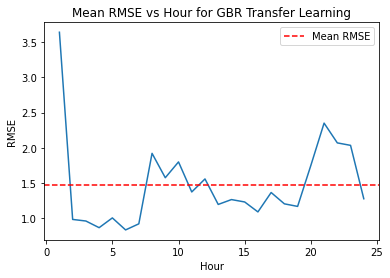

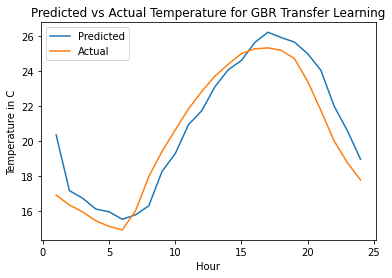

In [505]:
visualizer.plot_mean(model_dict_new,'GBR Transfer Learning',col_list)

**Model 2 : XGBoost**

Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/GradientBoostingRegressor/GradientBoostingRegressor_42.sav
Root Mean Squared Error : 2.7913053243129595


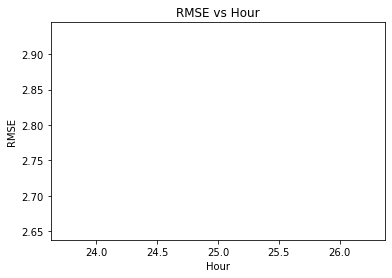

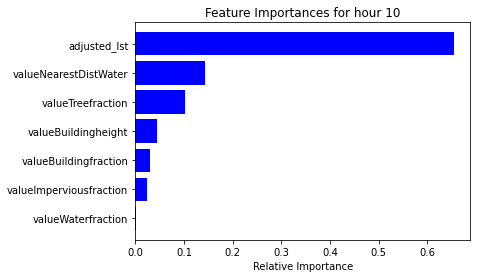

In [142]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

col_list = [
    # 'latitude', 'longitude', 
            # 'hour',  
          #   'closest_station_1_temp','closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']

gbr = GBR()

data,hour_status = get_partitions(grouped_data,col_list)  #or None
pred_df = mod.train_save(gbr, data, hour_flag=hour_status,)

pred_df['error'] = ((pred_df['predicted_temperature'] - pred_df['true_temperature'])**2)
error_df = pred_df.groupby('hour').mean().reset_index()
error_df['error'] = np.sqrt(error_df['error'])

plt.figure()
plt.plot(error_df['hour'],error_df['error'])
plt.xlabel('Hour')
plt.ylabel('RMSE')
plt.title('RMSE vs Hour')

plt.figure()
visualizer.plot_feature_importances(gbr, col_list, 10)

In [137]:
hour_status

False

In [144]:
data,hour_status = get_partitions(grouped_data,col_list)  #or None
hour_status

False

In [643]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 20),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 500)
}


col_list = [
    # 'latitude', 'longitude', 
            # 'hour', 
          #   'closest_station_1_temp','closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']

# data,hour_status = get_partitions([15],col_list)  #or None
data,hour_status = get_partitions(grouped_data,col_list,[12])  #or None
# mod.train_save(rrf, data, hour_flag=hour_status)


xgb_model = xgb.XGBRegressor()
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist,scoring='r2', n_iter=10, cv=5,verbose=3)

random_search.fit(data[0], data[2])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.07238814626032282, max_depth=19, n_estimators=323, subsample=0.8514343689179709;, score=-0.797 total time=   0.3s
[CV 2/5] END learning_rate=0.07238814626032282, max_depth=19, n_estimators=323, subsample=0.8514343689179709;, score=-0.338 total time=   0.2s
[CV 3/5] END learning_rate=0.07238814626032282, max_depth=19, n_estimators=323, subsample=0.8514343689179709;, score=-0.741 total time=   0.2s
[CV 4/5] END learning_rate=0.07238814626032282, max_depth=19, n_estimators=323, subsample=0.8514343689179709;, score=-0.608 total time=   0.3s
[CV 5/5] END learning_rate=0.07238814626032282, max_depth=19, n_estimators=323, subsample=0.8514343689179709;, score=-0.427 total time=   0.3s
[CV 1/5] END learning_rate=0.09849554266305292, max_depth=14, n_estimators=343, subsample=0.5940439728717974;, score=-0.684 total time=   0.2s
[CV 2/5] END learning_rate=0.09849554266305292, max_depth=14, n_estimators=343, s

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14454d6a0>,
            

Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_0.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_1.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_2.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_3.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_4.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_5.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_6.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_7.sav
Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/XGBRegressor/XGBRegressor_8.sav
M

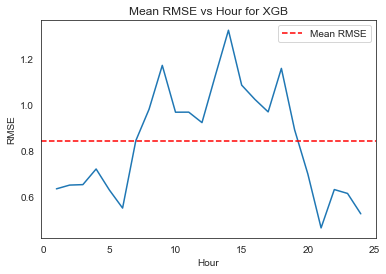

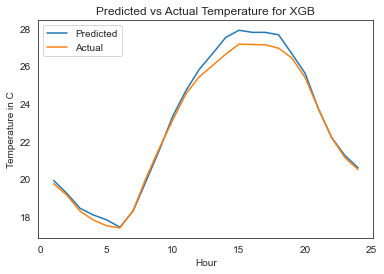

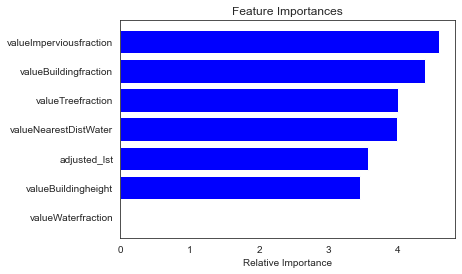

In [646]:

xgb_model = xgb.XGBRegressor(**random_search.best_params_)

col_list = [
    # 'latitude', 'longitude', 
        #     'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']


model_dict = bulk_model_runner(xgb_model,grouped_data,col_list,bulk_mode=True,delete=True)
visualizer.plot_mean(model_dict,'XGB',col_list)




### Neural Networks

In [50]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

col_list = [
    # 'latitude', 'longitude', 
            # 'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
       'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']

data,hour_status = get_partitions(grouped_data,col_list,[12])  #or None

nn = MLPRegressor(hidden_layer_sizes=(15,10,5),activation='relu', solver='adam', max_iter=500)
mod.train_save(nn, data,hour_flag=hour_status)

Model Saved : /Users/gaurav/UAH/temperature_modelling/Resources/trained_models/MLPRegressor/MLPRegressor_0.sav
Root Mean Squared Error : 1.2426048522485922


/Users/gaurav/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



## Bulk Runs

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR
import xgboost as xgb

col_list = [
    # 'latitude', 'longitude', 
    # 'hour', 
    # 'closest_station_1_temp',
    # 'closest_1_distance',
    # 'day_of_year', 
    'adjusted_lst',
    'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
    'valueNearestDistWater',
    'valueWaterfraction', 'valueBuildingfraction']

rrf = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                            n_estimators=300)
gbr = GBR()
# xgb_model = xgb.XGBRegressor(**random_search.best_params_)

# model_list = [rrf, gbr, xgb_model]
model_list = [rrf]
# xx  =[]
final_dict = dict()

for model in model_list:
    error_dict_scaled = {}

    for i in range(0, 24, 1):
        print(f'Hour : {i}')
        data, hour_status = get_partitions(grouped_data, col_list, [i])  # or None
        error = mod.train_save(model, data, hour_flag=hour_status, bulk_mode=True)
        error_dict_scaled[i] = error

    # xx.append(error_dict_scaled)
    final_dict[model.__class__.__name__] = error_dict_scaled



In [44]:
for i in range(0,24,1):
    print(f'Hour : {i}')
    data,hour_status = get_partitions(grouped_data,col_list,[i])  #or None
    error = mod.train_save(gbr, data, hour_flag=hour_status,bulk_mode=True)
    error_dict_scaled[i] = error


In [746]:
def get_delta_plots(final_dict):
    ''' Final dict is of format : 
        { {hour : [predictions,error,feature_importances]}}
        access : final_dict[0][0],final_dict[5][0]
    '''
    df_ = final_dict[0][0]
    df_ = df_[['predicted_temperature','true_temperature','hour']]
    df_['hour']  = 0

    for hrs in final_dict.keys():
        if hrs ==0:
            continue
        datax = final_dict[hrs][0]
        datax = datax[['predicted_temperature','true_temperature','hour']]
        datax['hour']  = hrs

        df_ = pd.concat([df_,datax])

    df_agg = df_.groupby('hour').mean().reset_index()
    df_agg['delta_temp'] = df_agg.predicted_temperature - df_agg.true_temperature

    rmse = [val[1] for val in final_dict.values()]
    avg_rmse = np.mean(rmse)

    df_['station'] = df_.index
    df_['delta'] = df_.predicted_temperature - df_.true_temperature
    df_ = df_.reset_index().drop('index',axis=1)


    import seaborn as sns
    # sns.set_theme(style="whitegrid")
    sns.set_style("white")
    plt.figure(figsize=(15,15))

    plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
    sns.lineplot(x=df_agg.hour,y=df_agg.delta_temp)
    plt.title('Average of Delta Temperature for all stations')
    plt.xlabel('Hour')
    plt.grid()

    plt.ylabel('Delta Temperature')


    plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
    sns.lineplot(x = df_agg.hour,y = df_agg.true_temperature,label='True Temperature')
    sns.lineplot(x = df_agg.hour,y = df_agg.predicted_temperature,label='Predicted Temperature')
    plt.title(f'True Temperature VS Predicted for test data : Avg RMSE = {round(avg_rmse,3)}')
    plt.xlabel('Hour')
    plt.ylabel('Temperature')

    # Create a subplot that spans the entire second row
    plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=2)
    df_['station'] = df_['station'].astype(str)
    sns.lineplot(x='hour', y='delta', hue='station', data=df_, marker='o')
    plt.title('Delta Temperature for all stations')
    # Show the plot)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



    # plt.tight_layout()
    plt.show()

get_delta_plots(model_dict)

KeyError: 0

In [747]:
df_ = final_dict['XGBRegressor'][0][0]
df_ = df_[['predicted_temperature','true_temperature','hour']]
df_['hour']  = 0

for hrs in final_dict['XGBRegressor'].keys():
    if hrs ==0:
        continue
    datax = final_dict['XGBRegressor'][hrs][0]
    datax = datax[['predicted_temperature','true_temperature','hour']]
    datax['hour']  = hrs

    df_ = pd.concat([df_,datax])

df_agg = df_.groupby('hour').mean().reset_index()
df_agg['delta_temp'] = df_agg.predicted_temperature - df_agg.true_temperature

rmse = [val[1] for val in final_dict['XGBRegressor'].values()]
avg_rmse = np.mean(rmse)

df_['station'] = df_.index
df_['delta'] = df_.predicted_temperature - df_.true_temperature
df_ = df_.reset_index().drop('index',axis=1)


import seaborn as sns
# sns.set_theme(style="whitegrid")
sns.set_style("white")
plt.figure(figsize=(15,15))

plt.subplot2grid((2, 2), (0, 0), rowspan=1, colspan=1)
sns.lineplot(x=df_agg.hour,y=df_agg.delta_temp)
plt.title('Average of Delta Temperature for all stations')
plt.xlabel('Hour')
plt.ylabel('Delta Temperature')


plt.subplot2grid((2, 2), (0, 1), rowspan=1, colspan=1)
sns.lineplot(x = df_agg.hour,y = df_agg.true_temperature,label='True Temperature')
sns.lineplot(x = df_agg.hour,y = df_agg.predicted_temperature,label='Predicted Temperature')
plt.title(f'True Temperature VS Predicted for test data : Avg RMSE = {round(avg_rmse,3)}')
plt.xlabel('Hour')
plt.ylabel('Temperature')

# Create a subplot that spans the entire second row
plt.subplot2grid((2, 2), (1, 0), rowspan=1, colspan=2)
df_['station'] = df_['station'].astype(str)
sns.lineplot(x='hour', y='delta', hue='station', data=df_, marker='o')
plt.title('Delta Temperature for all stations')
# Show the plot)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



# plt.tight_layout()
plt.show()


KeyError: 'XGBRegressor'

Testing with updated data


In [658]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

col_list = [
    # 'latitude', 'longitude', 
            'hour', 
            # 'closest_station_1_temp',
            # 'closest_1_distance',
      #  'day_of_year', 
       'adjusted_lst',
       'valueImperviousfraction', 'valueTreefraction', 'valueBuildingheight',
       'valueNearestDistWater',
         'valueWaterfraction', 'valueBuildingfraction']

rrf = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=8,
                            n_estimators=300)


# model_dict = bulk_model_runner(rrf,grouped_data,col_list,bulk_mode=True,delete=True)
# visualizer.plot_mean(model_dict,'Random Forest',col_list)


grouped_data.station.unique().shape

(105,)